In [1]:
# CELL 1: KHAI BÁO THƯ VIỆN VÀ CẤU HÌNH ĐƯỜNG DẪN

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import seaborn as sns
import random
import shutil  
import json    
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# CẤU HÌNH NGƯỠNG LỌC ẢNH CHÓI 
BRIGHT_PIXEL_THRESHOLD = 240   
BRIGHT_RATIO_THRESHOLD = 0.25


train_dir = r"../data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = r"../data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
test_dir  = r"../data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"


IMG_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 10

print(f"TensorFlow Version: {tf.__version__}")
print("Đã sẵn sàng để xử lý dữ liệu")

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow Version: 2.20.0
Đã sẵn sàng để xử lý dữ liệu


In [2]:
# CELL 2
# Kiểm tra ảnh có bị chói không
def is_overexposed_tf(img_path):
    try:
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        gray = tf.image.rgb_to_grayscale(img)

        bright_ratio = tf.reduce_mean(
            tf.cast(gray > BRIGHT_PIXEL_THRESHOLD, tf.float32)
        ).numpy()

        return bright_ratio > BRIGHT_RATIO_THRESHOLD, bright_ratio

    except Exception:
        return False, 0.0

In [3]:
# CELL 3
#Scan bright images in training set
report = {}

for cls in os.listdir(train_dir): # Đã đổi thành train_dir từ Cell 1
    cls_path = os.path.join(train_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    bad_count = 0
    total = 0

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        total += 1
        is_bad, _ = is_overexposed_tf(img_path)
        if is_bad:
            bad_count += 1

    report[cls] = (bad_count, total)
    print(f"{cls}: {bad_count}/{total} ảnh chói")

Apple___Apple_scab: 0/2016 ảnh chói
Apple___Black_rot: 0/1987 ảnh chói
Apple___Cedar_apple_rust: 202/1760 ảnh chói
Apple___healthy: 1/2008 ảnh chói
Blueberry___healthy: 183/1816 ảnh chói
Cherry_(including_sour)___healthy: 0/1826 ảnh chói
Cherry_(including_sour)___Powdery_mildew: 0/1683 ảnh chói
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 0/1642 ảnh chói
Corn_(maize)___Common_rust_: 0/1907 ảnh chói
Corn_(maize)___healthy: 0/1859 ảnh chói
Corn_(maize)___Northern_Leaf_Blight: 0/1908 ảnh chói
Grape___Black_rot: 0/1888 ảnh chói
Grape___Esca_(Black_Measles): 0/1920 ảnh chói
Grape___healthy: 2/1692 ảnh chói
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 0/1722 ảnh chói
Orange___Haunglongbing_(Citrus_greening): 0/2010 ảnh chói
Peach___Bacterial_spot: 0/1838 ảnh chói
Peach___healthy: 281/1728 ảnh chói
Pepper,_bell___Bacterial_spot: 0/1913 ảnh chói
Pepper,_bell___healthy: 205/1988 ảnh chói
Potato___Early_blight: 0/1939 ảnh chói
Potato___healthy: 125/1824 ảnh chói
Potato___Late_blight: 0/193

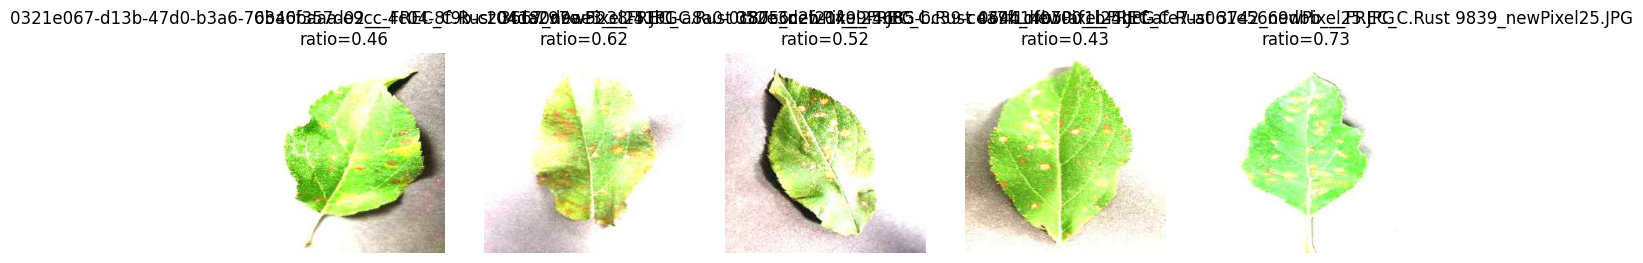

In [4]:
# CELL 4
#Show bad image
import matplotlib.pyplot as plt

def show_bright_images_train(cls, max_show=5):
    cls_path = os.path.join(train_dir, cls) 

    shown = 0
    plt.figure(figsize=(15, 5))

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        is_bad, ratio = is_overexposed_tf(img_path)

        if is_bad:
            img = tf.image.decode_jpeg(tf.io.read_file(img_path))
            plt.subplot(1, max_show, shown + 1)
            plt.imshow(img)
            plt.title(f"{img_name}\nratio={ratio:.2f}")
            plt.axis("off")

            shown += 1
            if shown >= max_show:
                break

    plt.show()
show_bright_images_train("Apple___Cedar_apple_rust")

In [5]:
# CELL 5
# Move bad images to separate folder
import shutil
MOVE_BAD = True

BAD_DIR = "./bad_images/train"
os.makedirs(BAD_DIR, exist_ok=True)

if MOVE_BAD:
    moved = 0
    for cls in os.listdir(train_dir): 
        cls_path = os.path.join(train_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        cls_bad_dir = os.path.join(BAD_DIR, cls)
        os.makedirs(cls_bad_dir, exist_ok=True)

        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            is_bad, _ = is_overexposed_tf(img_path)

            if is_bad:
                shutil.move(img_path, os.path.join(cls_bad_dir, img_name))
                moved += 1

    print(f"Đã move {moved} ảnh chói khỏi train")

Đã move 1941 ảnh chói khỏi train


In [7]:
# CELL 7
print("Đang Tải Dữ Liệu")

# Load tập Train (để học)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=123
)

# Load tập Valid (để kiểm tra trong lúc học)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=123
)

# Load tập Test (để chấm điểm độc lập sau khi học xong)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=123,
    shuffle=False # Không trộn tập test để dễ đối chiếu
)

class_names = train_ds.class_names
num_classes = len(class_names)

print(f"\nSố lượng lớp bệnh: {num_classes}")


AUTOTUNE = tf.data.AUTOTUNE


train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Đang Tải Dữ Liệu
Found 68354 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.

Số lượng lớp bệnh: 38


In [8]:
# CELL 8
# Tạo lớp Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),      # Lật ngang
    layers.RandomRotation(0.1),           # Xoay 10%
    layers.RandomZoom(0.1),               # Phóng to/nhỏ 10%
    layers.RandomContrast(0.1),           # Chỉnh tương phản
    # ***Dùng hàm tiền xử lý chuẩn của ResNet50***
    layers.Lambda(preprocess_input)       
], name="data_augmentation")

print("Đã thiết lập Data Augmentation cho ResNet50")

Đã thiết lập Data Augmentation cho ResNet50


In [9]:
# CELL 9
print("Đang TẢI Model Resnet50 (TRANSFER LEARNING)")

# 1. Tải khung sườn ResNet50 (ImageNet weights)
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

# 2. Đóng băng các lớp cũ
base_model.trainable = False

# 3. Ghép nối kiến trúc
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)   # Qua lớp tăng cường
x = base_model(x, training=False) # Qua ResNet
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)      # Loại bỏ bớt nơ-ron để chống Overfitting
x = layers.Dense(256, activation='relu')(x) # Lớp ẩn tăng cường khả năng học
outputs = layers.Dense(num_classes, activation="softmax")(x) # Lớp đầu ra

model = models.Model(inputs, outputs)
model.summary()

Đang TẢI Model Resnet50 (TRANSFER LEARNING)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,122,022 (92.02 MB)

 Trainable params: 534,310 (2.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
# CELL 10
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # Tốc độ học chậm(Để chắc chắn hơn)
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks 
checkpoint = ModelCheckpoint(
    "best_resnet50_model.keras", 
    save_best_only=True, 
    monitor="val_loss", 
    mode="min",
    verbose=1
)


early_stop = EarlyStopping(
    monitor="val_loss", 
    patience=15,            
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.2,             # Giảm tốc độ học nếu bị kẹt
    patience=3, 
    min_lr=1e-6,
    verbose=1
)

print("Đã Compile xong")

Đã Compile xong


In [11]:
# CELL 11
print(f"Bắt Đầu huấn luyện ({EPOCHS} Epochs)")

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Bắt Đầu huấn luyện (10 Epochs)
Epoch 1/10
8545/8545 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7476 - loss: 0.9561
Epoch 1: val_loss improved from None to 0.30995, saving model to best_resnet50_model.keras

Epoch 1: finished saving model to best_resnet50_model.keras
8545/8545 ━━━━━━━━━━━━━━━━━━━━ 1721s 201ms/step - accuracy: 0.8714 - loss: 0.4580 - val_accuracy: 0.9145 - val_loss: 0.3100 - learning_rate: 1.0000e-04
Epoch 2/10
8545/8545 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9463 - loss: 0.1685
Epoch 2: val_loss improved from 0.30995 to 0.25859, saving model to best_resnet50_model.keras

Epoch 2: finished saving model to best_resnet50_model.keras
8545/8545 ━━━━━━━━━━━━━━━━━━━━ 1702s 199ms/step - accuracy: 0.9502 - loss: 0.1554 - val_accuracy: 0.9330 - val_loss: 0.2586 - learning_rate: 1.0000e-04
Epoch 3/10
8545/8545 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9584 - loss: 0.1275
Epoch 3: val_loss improved from 0.25859 to 0.18707, saving model to best_resnet50_model.

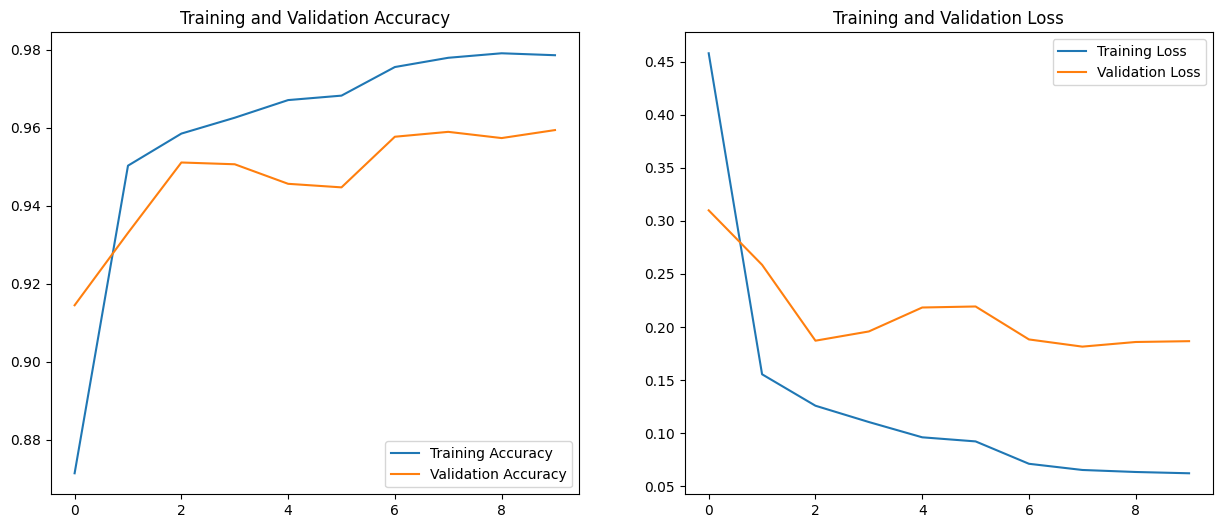

In [12]:
# CELL 12
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Đang chấm điểm trên tập test

 Bảng Báo Cáo chi tiết:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.94      0.99      0.96       504
                                 Apple___Black_rot       0.99      0.99      0.99       497
                          Apple___Cedar_apple_rust       1.00      0.95      0.97       440
                                   Apple___healthy       0.98      1.00      0.99       502
                               Blueberry___healthy       0.99      0.99      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      1.00       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.95      0.94       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maiz

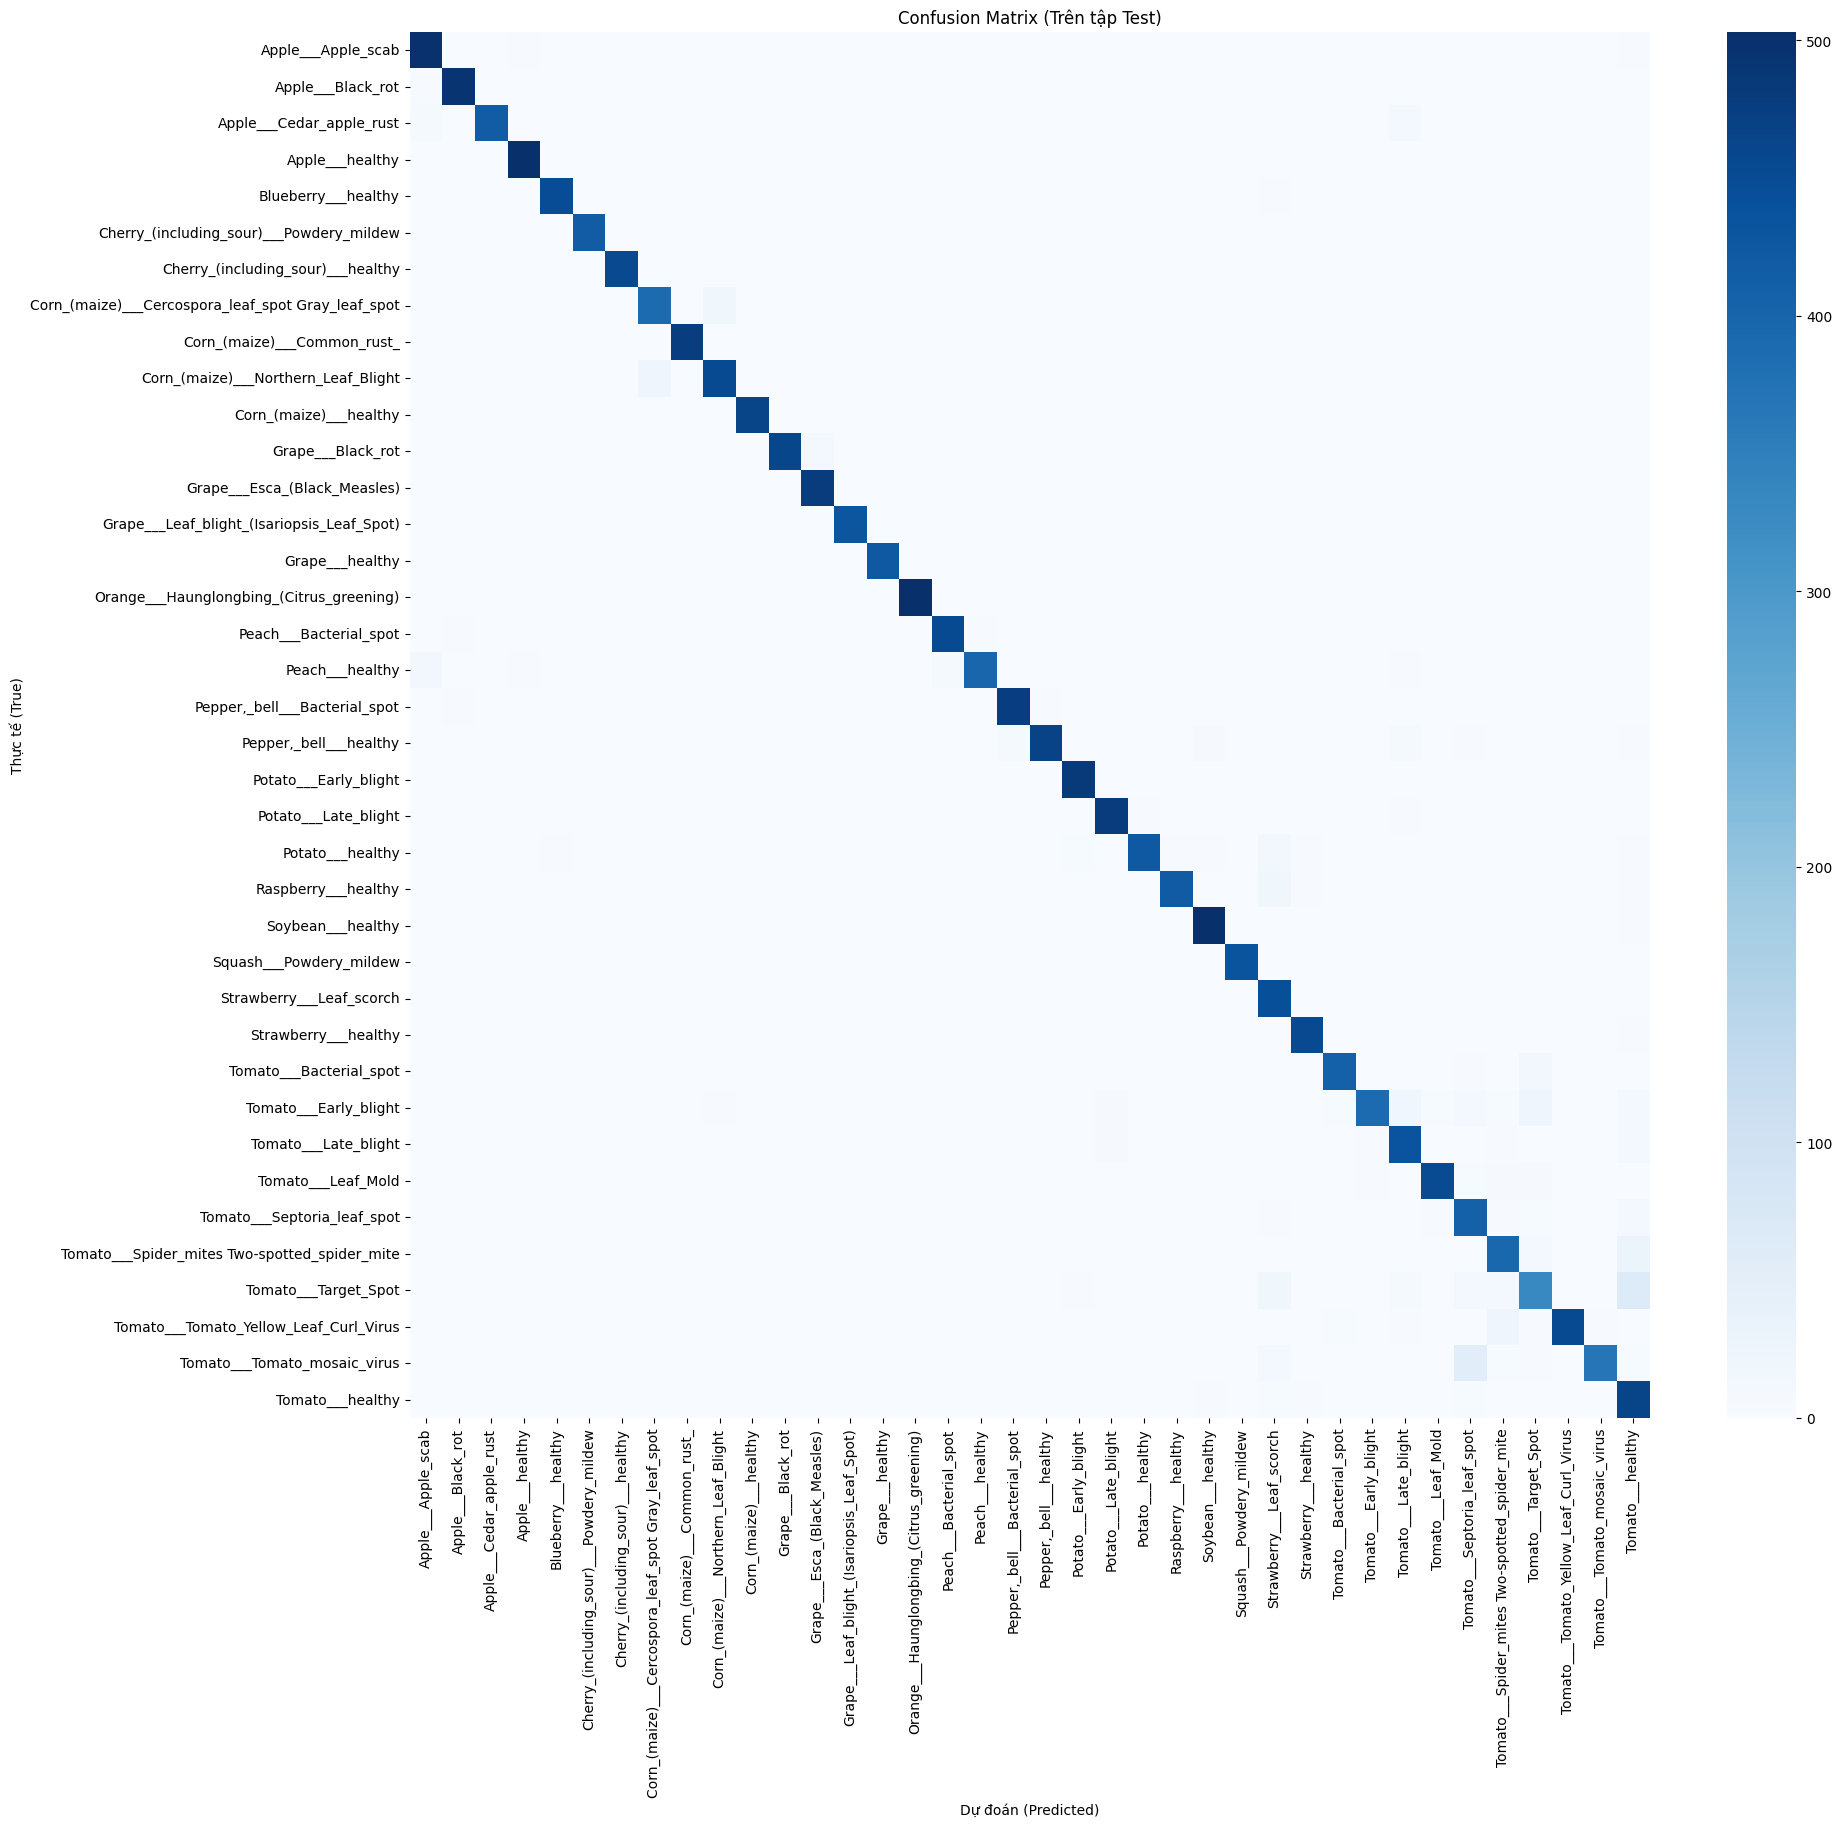

Độ chính xác tổng thể: 95.89%


In [13]:
# CELL 13
print("Đang chấm điểm trên tập test")

# Lấy nhãn thực tế và nhãn dự đoán từ tập Test
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Báo cáo chi tiết (Precision, Recall, F1-Score)
print("\n Bảng Báo Cáo chi tiết:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Vẽ Confusion Matrix
plt.figure(figsize=(20, 18))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (True)')
plt.title('Confusion Matrix (Trên tập Test)')
plt.xticks(rotation=90)
plt.show()
print(f"Độ chính xác tổng thể: {accuracy_score(y_true, y_pred)*100:.2f}%")

In [14]:
# CELL 14
import json

# 1. Lưu file model (bao gồm cả kiến trúc và trọng số)
model_path = "resnet50_final.keras"
model.save(model_path)
print(f"Đã lưu model tại: {model_path}")

# 2. Lưu danh sách tên các loại bệnh (để sau này dùng)
class_names_path = "class_names.json"
with open(class_names_path, "w", encoding="utf-8") as f:
    json.dump(class_names, f, ensure_ascii=False)
print(f"Đã lưu danh sách nhãn tại: {class_names_path}")

Đã lưu model tại: resnet50_final.keras
Đã lưu danh sách nhãn tại: class_names.json


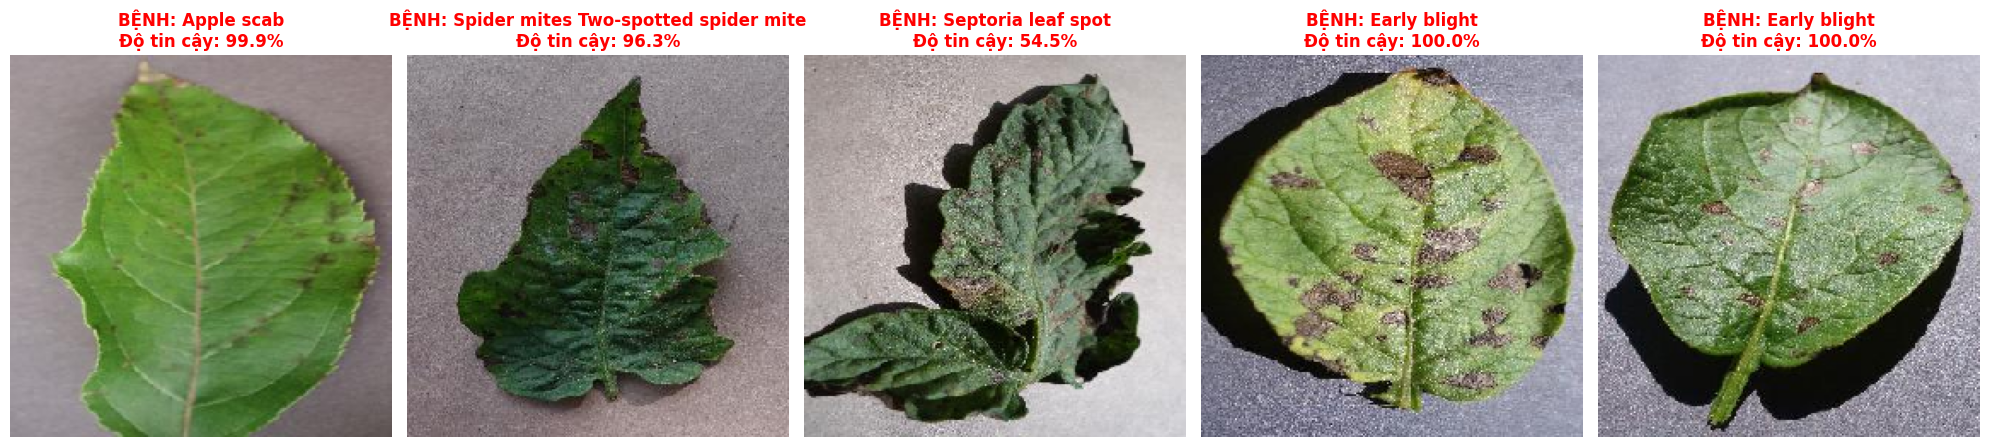

In [15]:
# CELL 15

demo_folder = r"../data/test/test"

# Lấy ngẫu nhiên 5 ảnh
all_files = [f for f in os.listdir(demo_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
random_files = random.sample(all_files, min(len(all_files), 5))

plt.figure(figsize=(20, 6))

for i, filename in enumerate(random_files):
    img_path = os.path.join(demo_folder, filename)
    
    # Load và preprocess
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    
    # Dự đoán
    pred = model.predict(img_arr, verbose=0)
    score = np.max(pred[0])         # Độ tin cậy cao nhất
    label_idx = np.argmax(pred[0])  # Vị trí nhãn
    label_name = class_names[label_idx]
    
    # Logic hiển thị Khỏe/Bệnh
    is_healthy = "healthy" in label_name.lower()
    color = 'green' if is_healthy else 'red'
    
    if is_healthy:
        status_text = f"Tình Trạng Khỏe Mạnh (100%)\n({label_name})"
    else:
        
        clean_name = label_name.split("___")[-1].replace("_", " ")
        status_text = f"BỆNH: {clean_name}\nĐộ tin cậy: {score*100:.1f}%"
    
    # Vẽ
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(status_text, color=color, fontweight='bold')

plt.tight_layout()
plt.show()